
# 🌍 Analyzing Hourly GPM IMERG Precipitation L3


In [1]:
import earthaccess 

print(f"using earthaccess version {earthaccess.__version__}")

auth = earthaccess.login(strategy="netrc")
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

using earthaccess version 0.5.1
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 05/13/2023
Using .netrc file for EDL


### Authentication in the cloud 
If the collection is a cloud-hosted collection we can print the `summary()` and get the S3 credential endpoint. These S3 credentials are temporary and we can use them with third party libraries such as s3fs, boto3 or awscli.

In [2]:
from pprint import pprint
results = earthaccess.search_datasets(doi = "10.5067/GPM/IMERG/3B-HH/06")

# Let's print our collections
for collection in results:
    # pprint(collection.summary())
    print(pprint(collection.summary()) ,"\n")

Datasets found: 1
{'cloud-info': {'Region': 'us-west-2',
                'S3BucketAndObjectPrefixNames': ['s3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHH.06/'],
                'S3CredentialsAPIDocumentationURL': 'https://data.gesdisc.earthdata.nasa.gov/s3credentialsREADME',
                'S3CredentialsAPIEndpoint': 'https://data.gesdisc.earthdata.nasa.gov/s3credentials'},
 'concept-id': 'C1598621093-GES_DISC',
 'file-type': "[{'FormatType': 'Native', 'Media': ['Online Archive'], "
              "'Format': 'HDF5', 'Fees': 'None'}]",
 'get-data': ['https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/',
              'https://search.earthdata.nasa.gov/search?q=GPM_3IMERGHH_06'],
 'short-name': 'GPM_3IMERGHH',
 'version': '06'}
None 



## A year of data 

Things to keep in mind:

* this is a high resolution dataset
* this is a global dataset
* temporal resolution is 30 minutes = 48 granules per day

With earthaccess we can programatically download this data (or access it directly in the cloud) but for the size of the dataset we have to batch our requests or reduce the scope for this example.

In [3]:
# count = 1 is important so we don't download the whole year! 
granules = earthaccess.search_data(count=1,
                                   concept_id="C1598621093-GES_DISC",
                                   temporal = ("2020-01","2021-01"))

Granules found: 17569


## Working with the URLs directly

If we chose, we can use `earthdata` to grab the file's URLs and then download them with another library (if we have a `.netrc` file configured with NASA's EDL credentials)
Getting the links to our data is quiet simple with the `data_links()` method on each of the results:

In [4]:
# on_prem is a bit misleading, the collection is cloud hosted, in this case the access can be done out of region 
granules[0].data_links(access="external")

['https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/2020/001/3B-HHR.MS.MRG.3IMERG.20200101-S000000-E002959.0000.V06B.HDF5']

In [5]:
granules[0].data_links(access="direct")

['s3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHH.06/2020/001/3B-HHR.MS.MRG.3IMERG.20200101-S000000-E002959.0000.V06B.HDF5']

## Downloading data

We are going to download 1 granule.


In [6]:
local_path = "./data"
files = earthaccess.download(granules[0:2], local_path=local_path)
files

 Getting 1 granules, approx download size: 0.01 GB


SUBMITTING | :   0%|          | 0/1 [00:00<?, ?it/s]

File 3B-HHR.MS.MRG.3IMERG.20200101-S000000-E002959.0000.V06B.HDF5 already downloaded


PROCESSING | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/1 [00:00<?, ?it/s]

['3B-HHR.MS.MRG.3IMERG.20200101-S000000-E002959.0000.V06B.HDF5']

In [7]:
from jupyterlab_h5web import H5Web
from pathlib import Path

file = Path(local_path) / Path(files[0])
H5Web(file)

<jupyterlab_h5web.widget.H5Web object>

In [8]:
%%time

results = []

# we just grab 1 granule from May for each year of the dataset
for year in range(2018, 2022):
    granules = earthaccess.search_data(
        concept_id="C1598621093-GES_DISC",
        temporal=(f"{year}-05-01", f"{year}-05-02"))
    if len(granules)>0:
        results.extend(granules)

print(len(results))

Granules found: 49
Granules found: 49
Granules found: 49
Granules found: 49
196
CPU times: user 466 ms, sys: 9.47 ms, total: 476 ms
Wall time: 39.3 s


In [9]:
results[0]

Collection: {'ShortName': 'GPM_3IMERGHH', 'Version': '06'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2018-05-01T00:00:00.000Z', 'EndingDateTime': '2018-05-01T00:29:59.999Z'}}
Size(MB): 9.848882675170898
Data: ['https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/2018/121/3B-HHR.MS.MRG.3IMERG.20180501-S000000-E002959.0000.V06B.HDF5']

In [10]:
%%time 

file = earthaccess.open(results[0:1])

 Opening 1 granules, approx size: 0.01 GB


SUBMITTING | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 77.9 ms, sys: 8.28 ms, total: 86.2 ms
Wall time: 1.69 s


## Plotting 

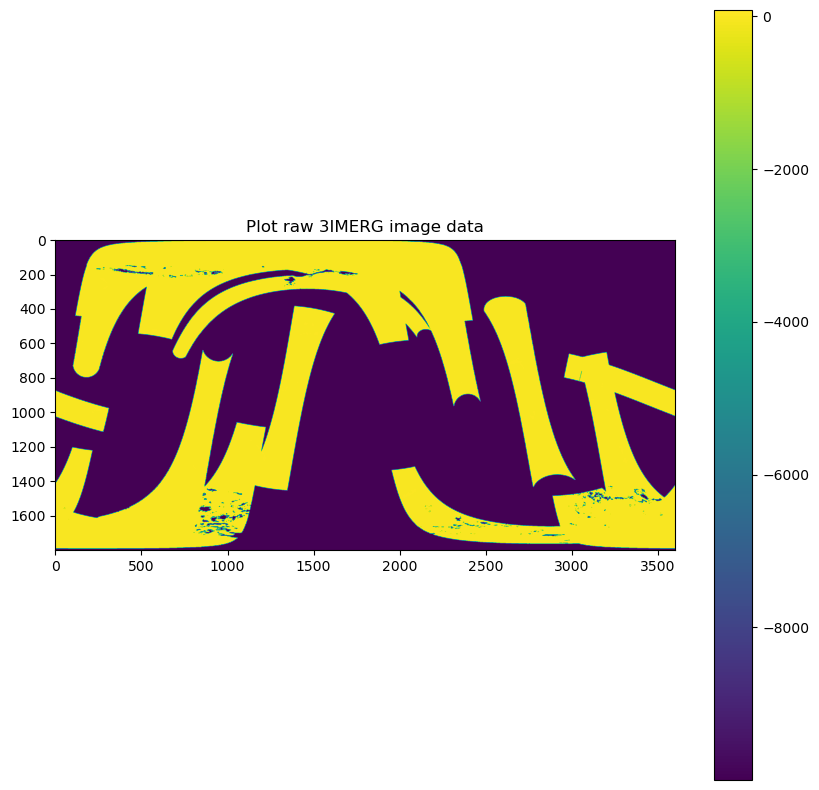

In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File(file[0], 'r') as h5file:
    img_arr = np.transpose(h5file['/Grid/HQprecipitation'][0,:,:])
    
fig = plt.subplots(figsize=(10,10)) 
plt.title('Plot raw 3IMERG image data')
im = plt.imshow(img_arr) 
plt.colorbar(im)